# Dissect complexome-wide, disease-specific functional perturbations.

### Uses proteomics data (log2FC) for comparing conditions (e.g., disease vs normal). Scans annotated protein complexes right across the cellular landscape and identifies disease-associated perturbations in protein complexes and subunits.

#### For an application of the pipeline to metabolic disease, see https://www.biorxiv.org/content/10.1101/2023.12.30.573613v1

In [23]:
import csv, time, pickle, operator
import pandas as pd
import textwrap
from textwrap import wrap
from unipressed import IdMappingClient
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Specify input file names and locations, set parameters (or keep default values).

In [7]:
organism_taxon_id = "9606"
ComplexomeObject = "9606Complexome_2024-05-14.pickle"
ComplexNamesObject = "9606ComplexNames_2024-05-14.pickle"
ComplexGOTermsObject = "9606ComplexGOTerms_2024-05-14.pickle"
ProteomicsDEResultsFile = "/Users/mainak/Documents/Projects/Karen_multiomics_glycosylation/TM_vs_EtOH_preNorm_LoDimputation/TM_processedProteomicsFile.csv" # Proteomics DE results: each row should contain a UniProt ID and the corresponding log2FC and adj. Pvalue.
outputFileName = "sample_GlobalPerturbedComplexes.csv" # Details of the perturbed complexes and the regulated subunit(s).
ONLY_REGULATED_SUBUNITS = True # If True, output only those complexes where at least one subunit has a fold change and adj. pvalue corresponding to selected thresholds.
LOG2FC_THRESHOLD = 2.0
ADJP_THRESHOLD = 0.05
topN_GOterms_to_plot = 10 # Select how many top occurring GO terms to plot. The output figure dimensions may need to be modified in order to fit a larger number of GO term labels.

In [8]:
# Function to word wrap long GO term names (used as axis labels).
def wrap_labels(ax, width, break_long_words=False):
    # Based on https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticks(np.arange(topN_GOterms_to_plot)) # new addition -- checking.
    ax.set_xticklabels(labels, rotation=40, ha='right', va='top')

In [9]:
# Open the pre-parsed complex portal pickled dictionary.
with open(ComplexomeObject, "rb") as input:
    Complexes = pickle.load(input)

with open(ComplexNamesObject, "rb") as input:
    ComplexNames = pickle.load(input)

with open(ComplexGOTermsObject, "rb") as input:
    ComplexGOTerms = pickle.load(input)

In [10]:
print("Number of complexes in the complexome version being used:",len(Complexes))
# Internal check.
if len(Complexes) != len(ComplexNames):
    print("Potential issue. Number of complexes and corresponding name entries do not match!!")

Number of complexes in the complexome version being used: 2050


In [11]:
# Open and parse the proteomics data into a dictionary containing per-protein log2FC and adj. p-values.
isHeader = True # The proteomics csv data file contains a header line. Set to 'False' otherwise.
uniprotID_column=1
log2FC_column=2
adjPval_column=6

proteomicsData = {}
with open(ProteomicsDEResultsFile) as csvFile:
    csvReader = csv.reader(csvFile, delimiter=',')
    for row in csvReader:
        if isHeader:
            isHeader = False
            continue
        else:
            uniprotID = row[uniprotID_column]
            log2FC = row[log2FC_column]
            adjPVal = row[adjPval_column]
            proteomicsData[uniprotID] = [log2FC, adjPVal]

In [12]:
print("Number of quantified proteins in this dataset:", len(proteomicsData))

Number of quantified proteins in this dataset: 4462


In [13]:
# Uncomment to check log2FC and qvalue for the whole input dataset or for individual protein(s) of interest. Specify the UniProt id as necessary.
#print(proteomicsData)
#print(proteomicsData['Q9HD42'])

In [14]:
# Iterate over all known complexes and identify complexes with one or more perturbed subunits.
allPerturbedComplexes = []
for complexId in Complexes:
    complexMembers = Complexes[complexId]
    complexName = ComplexNames[complexId]

    # Check if at least one member of this complex has an omics measurement.
    OmicsMeasuredComplex = False
    measuredSubunits = [] # Has an omics measurement.
    regulatedSubunits = [] # Fulfills the criteria for a differentially expressed subunit.

    for member in complexMembers:
        if member in proteomicsData:
            measuredSubunits.append(member)
            if ONLY_REGULATED_SUBUNITS:
                log2FCValue = abs(float(proteomicsData[member][0]))
                adjPValue = round(float(proteomicsData[member][1]),2)
                if log2FCValue >= LOG2FC_THRESHOLD and adjPValue <= ADJP_THRESHOLD:
                    OmicsMeasuredComplex = True
                    regulatedSubunits.append(member)
                else:
                    OmicsMeasuredComplex = True

    if OmicsMeasuredComplex:
        for subunit in regulatedSubunits:
            subunitInfo=[complexId,complexName,subunit]
            for subunitData in proteomicsData[subunit]:
                subunitInfo.append(subunitData)
            allPerturbedComplexes.append(subunitInfo)

### How many perturbed complexes identified?

In [15]:
#print(allPerturbedComplexes)
print("Number of dysregulated complexes:", len(allPerturbedComplexes))

Number of dysregulated complexes: 40


In [16]:
dfPerturbedComplexes = pd.DataFrame(allPerturbedComplexes, columns=['ComplexID', 'Complex Name', 'SubunitID', 'Log2FC', 'Adj. Pvalue'])
print(dfPerturbedComplexes)

   ComplexID                                       Complex Name SubunitID  \
0    CPX-155     RB1-E2F1-DP1 transcriptional repressor complex    P06400   
1    CPX-175     RB1-E2F2-DP1 transcriptional repressor complex    P06400   
2    CPX-469                                    L3MBTL1 complex    P06400   
3    CPX-560        Mitochondrial respiratory chain complex III    P00156   
4    CPX-707  CCR4-NOT mRNA deadenylase complex, CNOT6-CNOT7...    Q9H9A5   
5   CPX-1196  Polybromo-associated SWI/SNF ATP-dependent chr...    Q86U86   
6   CPX-1199  Polybromo-associated SWI/SNF ATP-dependent chr...    Q86U86   
7   CPX-1285                        Laminin221-nidogen complex     P55268   
8   CPX-1605         WMM N6-adenosine-methyltransferase complex    Q86U44   
9   CPX-1605         WMM N6-adenosine-methyltransferase complex    Q9HCE5   
10  CPX-1772                                Laminin-121 complex    P55268   
11  CPX-1773                                Laminin-221 complex    P55268   

### Save the list of all perturbed complexes and details of their affected subunit(s) as a csv file.

In [17]:
# Save the list of dysregulated complexes and affected subunits as a csv file.
dfPerturbedComplexes.to_csv(outputFileName, index=False, float_format='%.2f', encoding='utf-8')

### Functional summary: bar chart of top occurring GO terms associated with perturbed complexes.

In [18]:
# Iterate over each of the perturbed complexes and identify the associated GO terms linked to the perturbed complexes.
affectedComplexesAllGOTerms = {}
for complex in allPerturbedComplexes:
    associatedGOTerms = ComplexGOTerms[complex[0]]
    #print(associatedGOTerms) # See if any filters need to be integrated here? Either based on BP, MF, CC terms or based on hierarcy level(s)?

    # Add the GO terms of this complex to the dictionary tracking the overall GO terms of all affected complexes.
    for goTerm in associatedGOTerms:
        if goTerm not in affectedComplexesAllGOTerms:
            affectedComplexesAllGOTerms[goTerm] = 1
        else:
            affectedComplexesAllGOTerms[goTerm] += 1
#print(affectedComplexesAllGOTerms)
print("Number of unique GO terms associated with the affected complexes:",len(affectedComplexesAllGOTerms))

Number of unique GO terms associated with the affected complexes: 107


In [19]:
# Plot the top N GO terms in the affected complexes.
# First, sort by descending order of GO term occurrence frequency.
sorted_d = dict(sorted(affectedComplexesAllGOTerms.items(), key=operator.itemgetter(1), reverse=True))
#print(sorted_d)
# Filter out the top N most frequent GO terms (for plotting). Set the value of topN at the beginning of the script.
filtered_d = dict(sorted(affectedComplexesAllGOTerms.items(), key=operator.itemgetter(1), reverse=True)[:topN_GOterms_to_plot])
#print(filtered_d)

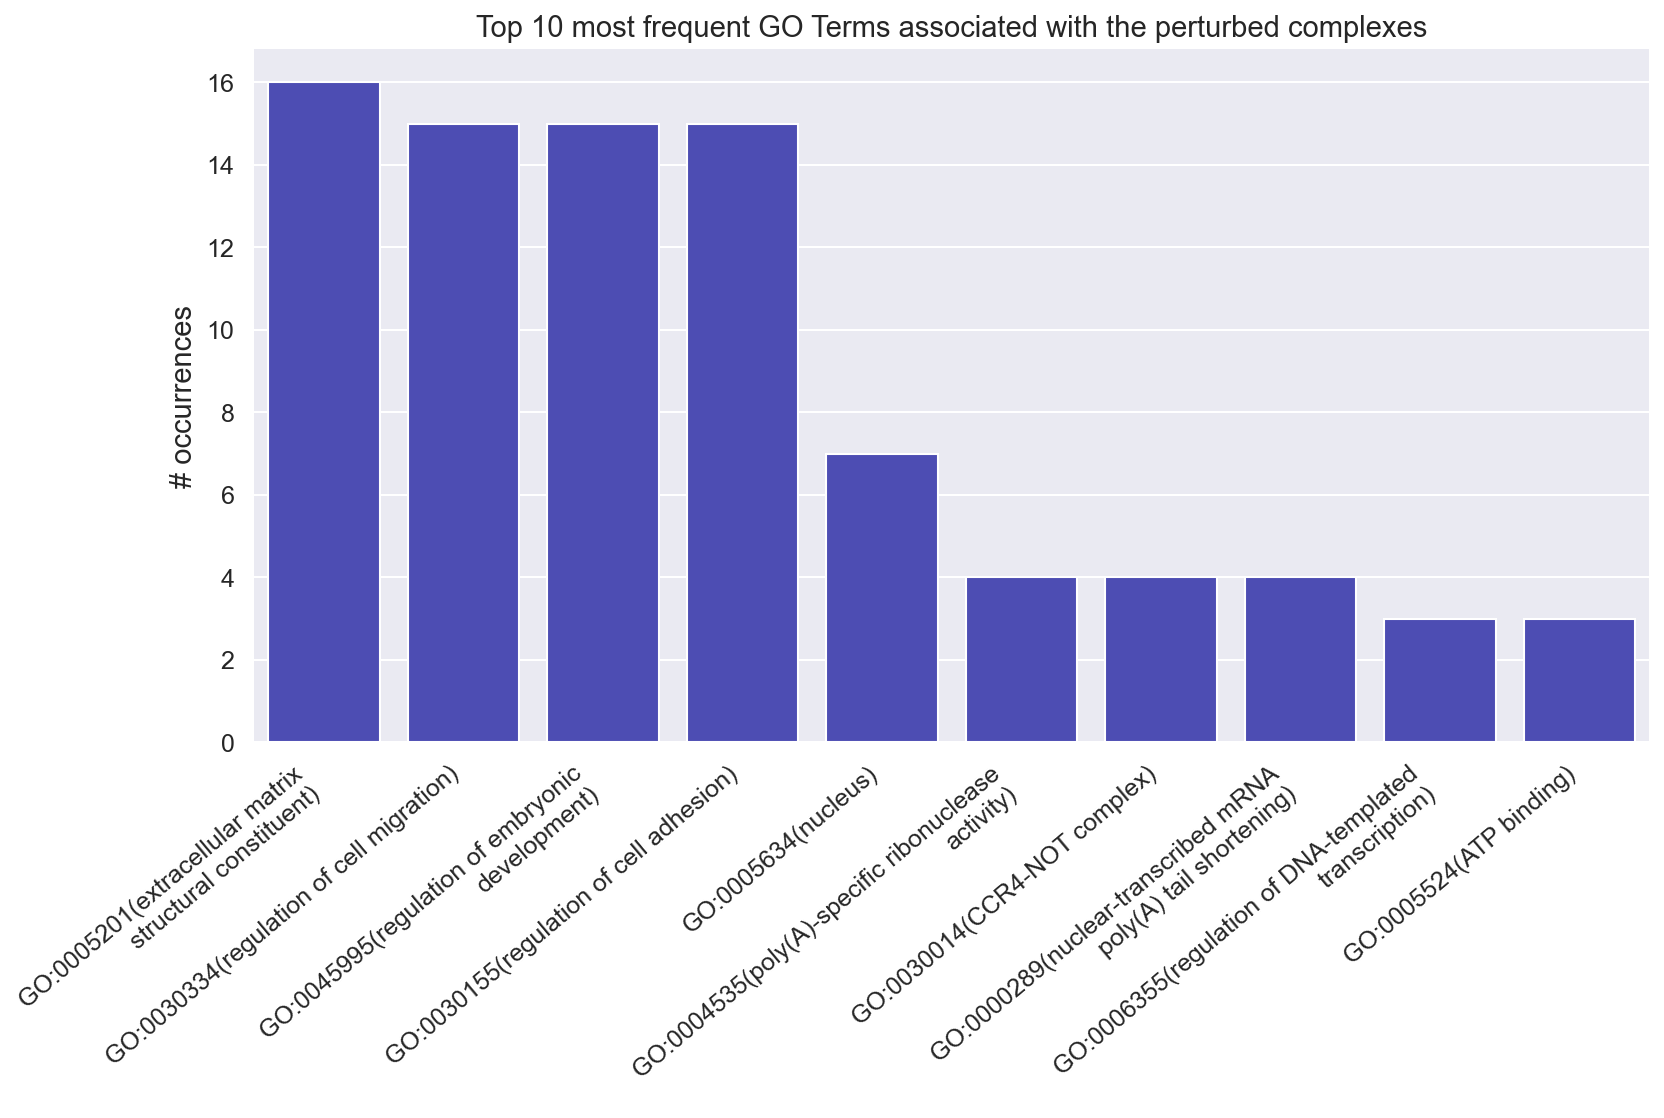

In [20]:
# Create the bar plot.
sns.set_theme(style='whitegrid', rc={'figure.dpi': 150},font_scale=0.64)
sns.set_color_codes('pastel')
sns.set(rc={'figure.figsize':(12,6)})
fig, ax = plt.subplots()
sns.barplot(x=list(filtered_d.keys()), y=[filtered_d[k] for k in filtered_d.keys()], color='blue', saturation=.4)
sns.despine(left=True, bottom=False)
wrap_labels(ax, 40)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('# occurrences', fontsize=14)
plt.title("Top " + str(topN_GOterms_to_plot) + " most frequent GO Terms associated with the perturbed complexes", fontsize=14)
#plt.tight_layout()
plt.show()

### For complexes of interest, output all subunit names and their corresponding protein log2FC, adj. P-values.

In [27]:
complex_ids_of_interest = ["CPX-1772", "CPX-1773"] # User-supplied complex identifier(s) from the list of affected complexes identified previously.
for complex in Complexes:
    if complex in complex_ids_of_interest:
        print("Complex Portal identifier:", complex)
        print("Complex Name:", ComplexNames[complex])
        print("Subunit UniProt IDs:", Complexes[complex])
        subunits = Complexes[complex]
        for subunit in subunits:
            request = IdMappingClient.submit(source="UniProtKB_AC-ID", dest="Gene_Name", ids={subunit}) # API call to UniProt to map UniProt ID to the corresponding Gene Name.
            time.sleep(3) # Put a 3 seconds wait time for the ID conversion to complete.
            subunitGeneName = list(request.each_result())[0]['to']
            try:
                subunit_log2FC = proteomicsData[subunit]
            except KeyError:
                subunit_log2FC = 'Not Measured'

            print(subunit, subunitGeneName, "[Log2FC, adj.Pval]:", subunit_log2FC)
        print()

Complex Portal identifier: CPX-1772
Complex Name: Laminin-121 complex
Subunit UniProt IDs: ['P11047', 'P25391', 'P55268']
P11047 LAMC1 [Log2FC, adj.Pval]: ['0.79067', '2.3604e-07']
P25391 LAMA1 [Log2FC, adj.Pval]: Not Measured
P55268 LAMB2 [Log2FC, adj.Pval]: ['1.2929', '2.637e-09']

Complex Portal identifier: CPX-1773
Complex Name: Laminin-221 complex
Subunit UniProt IDs: ['P11047', 'P24043', 'P55268']
P11047 LAMC1 [Log2FC, adj.Pval]: ['0.79067', '2.3604e-07']
P24043 LAMA2 [Log2FC, adj.Pval]: Not Measured
P55268 LAMB2 [Log2FC, adj.Pval]: ['1.2929', '2.637e-09']



### <font color='red'>****WISH LIST for Software Development: visualization options.</font>
#### <font color='green'>Network view</font> per complex, subunits as circles, colored by log2FC, values displayed on mouse over, etc.
#### Create hyperlinks from notebook output --> Complex Portal (for further reading, publications describing the complex, etc.)

#### ****TO ADD: map CPX- and UniProt IDs to Reactome.